In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')
import tensorflow as tf
print(tf.test.is_built_with_cuda())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Mon Nov 16 00:38:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import nibabel as nib
from scipy import ndimage
import os


def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

In [69]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "/content/sample_data/MRI/train/cn", x)
    for x in os.listdir("/content/sample_data/MRI/train/cn")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "/content/sample_data/MRI/train/ad", x)
    for x in os.listdir("/content/sample_data/MRI/train/ad")
]

print("Normal control scans with normal brain tissue: " + str(len(normal_scan_paths)))
print("Alzheimer's scans with abnormal brain tissue: " + str(len(abnormal_scan_paths)))

Normal control scans with normal brain tissue: 82
Alzheimer's scans with abnormal brain tissue: 82


In [70]:
import numpy as np
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])


x_train = np.concatenate((abnormal_scans[:60], normal_scans[:60]), axis=0)
y_train = np.concatenate((abnormal_labels[:60], normal_labels[:60]), axis=0)
x_val = np.concatenate((abnormal_scans[22:], normal_scans[22:]), axis=0)
y_val = np.concatenate((abnormal_labels[22:], normal_labels[22:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 120 and 120.


In [45]:
import random

from scipy import ndimage

def train_preprocessing(volume, label):
    volume = tensorflow.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tensorflow.expand_dims(volume, axis=3)
    return volume, label

In [46]:
import os
import tensorflow.keras 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import numpy as np 
import cv2
import pandas as pd
from tensorflow.keras import backend

train_loader = tensorflow.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tensorflow.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 10

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the MRI scan is: (128, 128, 64, 1)


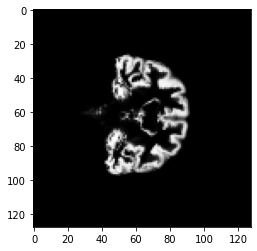

In [47]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

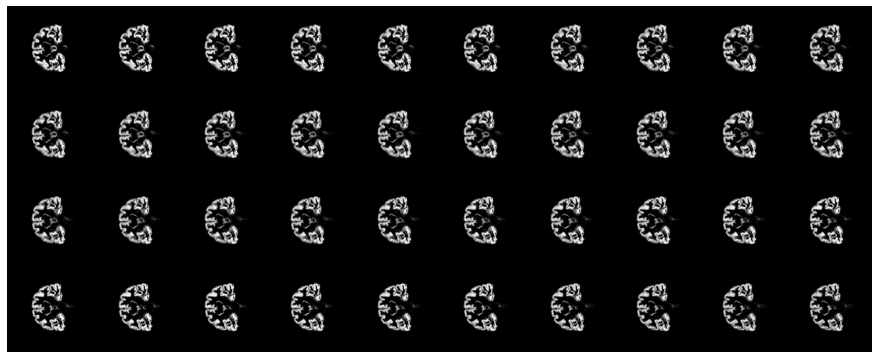

In [48]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(4, 10, 128, 128, image[:, :, :40])

In [49]:
image.shape

(128, 128, 64, 1)

In [57]:
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib 
from sklearn.model_selection import train_test_split
import math
import glob
import keras.layers
import tensorflow as tf
from tensorflow import keras

def get_model(width=128, height=128, depth=64):

    inputs = keras.Input((width, height, depth, 1))

    x = keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(units=512, activation="relu")(x)
    x = keras.layers.Dropout(0.4)(x)

    outputs = keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 126, 126, 62, 32)  896       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 63, 63, 31, 32)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 31, 32)    128       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 61, 61, 29, 64)    55360     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 14, 64)    256   

In [ ]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.95, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size = 20,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )